In [ ]:
!pip install labml
!pip install labml_nn

In [ ]:
import torch
import torch.nn as nn

from labml_nn.optimizers import GenericAdaptiveOptimizer, WeightDecay

import pandas as pd

import math

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from google.colab import drive
from google.colab import files

drive.mount("/content/drive/")

In [37]:
'''
Adam class implementation
|--> init
|--> init_state
|--> getmv
|--> getlr
|--> adapUpdate
|--> stepParam
'''

class Adam(GenericAdaptiveOptimizer):
  def __init__(self, params,
               lr : float = 1e-3,
               betas = (0.9, 0.999),
               eps : float = 1e-16,
               weightDecay = WeightDecay(),
               optimizedUpdate: bool = True,
               defaults = None
               ) -> None:

    defaults = {} if defaults is None else defaults
    defaults.update(weightDecay.defaults())
    super().__init__(params, defaults, lr, betas, eps)

    self.weightDecay = weightDecay
    self.optimizedUpdate = optimizedUpdate

  def init_state(self, state, group, param: nn.Parameter) -> None:
    state['step'] = 0
    state['expAvg'] = torch.zeros_like(param, memory_format=torch.preserve_format)
    state['expAvgSq'] = torch.zeros_like(param, memory_format=torch.preserve_format)

  def get_mv(self, state, group, grad: torch.Tensor):
    beta1, beta2 = group['betas']

    m,v = state['expAvg'], state['expAvgSq']
    m.mul_(beta1).add_(grad, alpha=1 - beta1)
    v.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

    return m,v

  def get_lr(self, state, group):
    return group["lr"]

  def adam_update(self, state, group, param : torch.nn.Parameter, m: torch.Tensor, v : torch.Tensor):
    beta1, beta2 = group['betas']

    biasCorrection1 = 1 - beta1 ** state['step']
    biasCorrection2 = 1 - beta2 ** state['step']

    lr = self.get_lr(state, group)

    if self.optimizedUpdate:
      denominator = v.sqrt().add_(group['eps'])
      stepSize = lr * math.sqrt(biasCorrection2) / biasCorrection1

      param.data.addcdiv_(m, denominator, value = -stepSize)

    else:
      denominator = (v.sqrt() / math.sqrt(biasCorrection2)).add_(group['eps'])
      stepSize = lr / biasCorrection1
      param.data.addcdiv_(m, denominator, value = -stepSize)

  def step_param(self, state, group, grad : torch.Tensor, param : torch.nn.Parameter):
    grad = self.weightDecay(param, grad, group)
    m, v = self.get_mv(state, group, grad)
    state['step'] += 1
    self.adam_update(state, group, param, m, v)


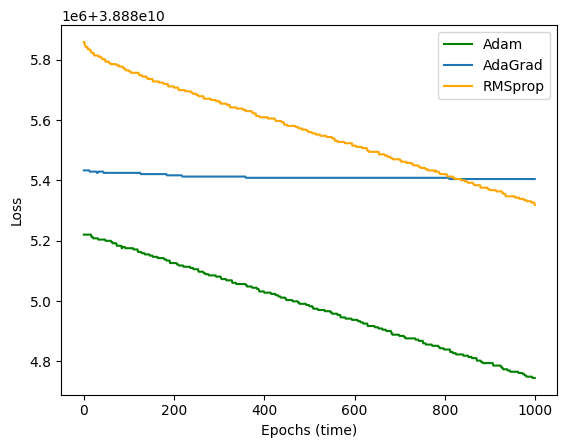

In [35]:
data = pd.read_csv("/content/drive/MyDrive/train.csv")
data = data[['GrLivArea', 'SalePrice']]

scaler = StandardScaler()
x = scaler.fit_transform(data[["GrLivArea"]].values)
y = data["SalePrice"].values.reshape(-1, 1)

xTensor = torch.tensor(x, dtype=torch.float32)
yTensor = torch.tensor(y, dtype=torch.float32)

xTrain, xVal, yTrain, yVal = train_test_split(xTensor, yTensor, test_size=0.2, random_state=42)

class testModel(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.Linear = nn.Linear(1,1)

  def forward(self, x):
    return self.Linear(x)

def train(model, optimizer, epochs=1000):

  criterion = nn.MSELoss()
  losses = []

  for i in range(epochs):
    optimizer.zero_grad()
    predictions = model(xTrain)
    loss = criterion(predictions, yTrain)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  return losses

#model 1
adamModel = testModel()
adamOptimizer = Adam(adamModel.parameters(), lr = 1e-3)
adamLosses = train(adamModel, adamOptimizer)

#model 2
adaGradModel = testModel()
adaGradmOptimizer = torch.optim.Adagrad(adaGradModel.parameters(), 1e-3)
adaGradLosses = train(adaGradModel, adaGradmOptimizer)

#model 3
RMSpropModel = testModel()
RMSpropOptimizer = torch.optim.RMSprop(RMSpropModel.parameters(), 1e-3)
RMSpropLosses = train(RMSpropModel, RMSpropOptimizer)


plt.plot(adamLosses, label="Adam", color='green')
plt.plot(adaGradLosses, label="AdaGrad")
plt.plot(RMSpropLosses, label="RMSprop",color='orange')
plt.xlabel("Epochs (time)")
plt.ylabel("Loss")
plt.legend()
plt.show()